<a href="https://colab.research.google.com/github/ad5454/Smart-Grid-Stability/blob/main/Grid_Stability.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score

In [7]:
df = pd.read_csv("/content/smart_grid_stability_augmented.csv.zip")
table = dict() # used for storing accuracy, precision, recall, f1score of each model
df.head()

,tau1,tau2,tau3,tau4,p1,p2,p3,p4,g1,g2,g3,g4,stab,stabf
0,2.959060,3.079885,8.381025,9.780754,3.763085,-0.782604,-1.257395,-1.723086,0.650456,0.859578,0.887445,0.958034,0.055347,unstable
1,9.304097,4.902524,3.047541,1.369357,5.067812,-1.940058,-1.872742,-1.255012,0.413441,0.862414,0.562139,0.781760,-0.005957,stable
2,8.971707,8.848428,3.046479,1.214518,3.405158,-1.207456,-1.277210,-0.920492,0.163041,0.766689,0.839444,0.109853,0.003471,unstable
3,0.716415,7.669600,4.486641,2.340563,3.963791,-1.027473,-1.938944,-0.997374,0.446209,0.976744,0.929381,0.362718,0.028871,unstable
4,3.134112,7.608772,4.943759,9.857573,3.525811,-1.125531,-1.845975,-0.554305,0.797110,0.455450,0.656947,0.820923,0.049860,unstable


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Data columns (total 14 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   tau1    60000 non-null  float64
 1   tau2    60000 non-null  float64
 2   tau3    60000 non-null  float64
 3   tau4    60000 non-null  float64
 4   p1      60000 non-null  float64
 5   p2      60000 non-null  float64
 6   p3      60000 non-null  float64
 7   p4      60000 non-null  float64
 8   g1      60000 non-null  float64
 9   g2      60000 non-null  float64
 10  g3      60000 non-null  float64
 11  g4      60000 non-null  float64
 12  stab    60000 non-null  float64
 13  stabf   60000 non-null  object 
dtypes: float64(13), object(1)
memory usage: 6.4+ MB


In [9]:
df.describe()

,tau1,tau2,tau3,tau4,p1,p2,p3,p4,g1,g2,g3,g4,stab
count,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000
mean,5.250000,5.250001,5.250001,5.250001,3.750000,-1.250000,-1.250000,-1.250000,0.525000,0.525000,0.525000,0.525000,0.015731
std,2.742434,2.742437,2.742437,2.742437,0.752129,0.433017,0.433017,0.433017,0.274244,0.274243,0.274243,0.274243,0.036917
min,0.500793,0.500141,0.500141,0.500141,1.582590,-1.999945,-1.999945,-1.999945,0.050009,0.050028,0.050028,0.050028,-0.080760
25%,2.874892,2.875011,2.875011,2.875011,3.218300,-1.624997,-1.624997,-1.624997,0.287521,0.287497,0.287497,0.287497,-0.015557
50%,5.250004,5.249981,5.249981,5.249981,3.751025,-1.249996,-1.249996,-1.249996,0.525009,0.525007,0.525007,0.525007,0.017142
75%,7.624690,7.624896,7.624896,7.624896,4.282420,-0.874993,-0.874993,-0.874993,0.762435,0.762490,0.762490,0.762490,0.044878
max,9.999469,9.999837,9.999837,9.999837,5.864418,-0.500025,-0.500025,-0.500025,0.999937,0.999982,0.999982,0.999982,0.109403


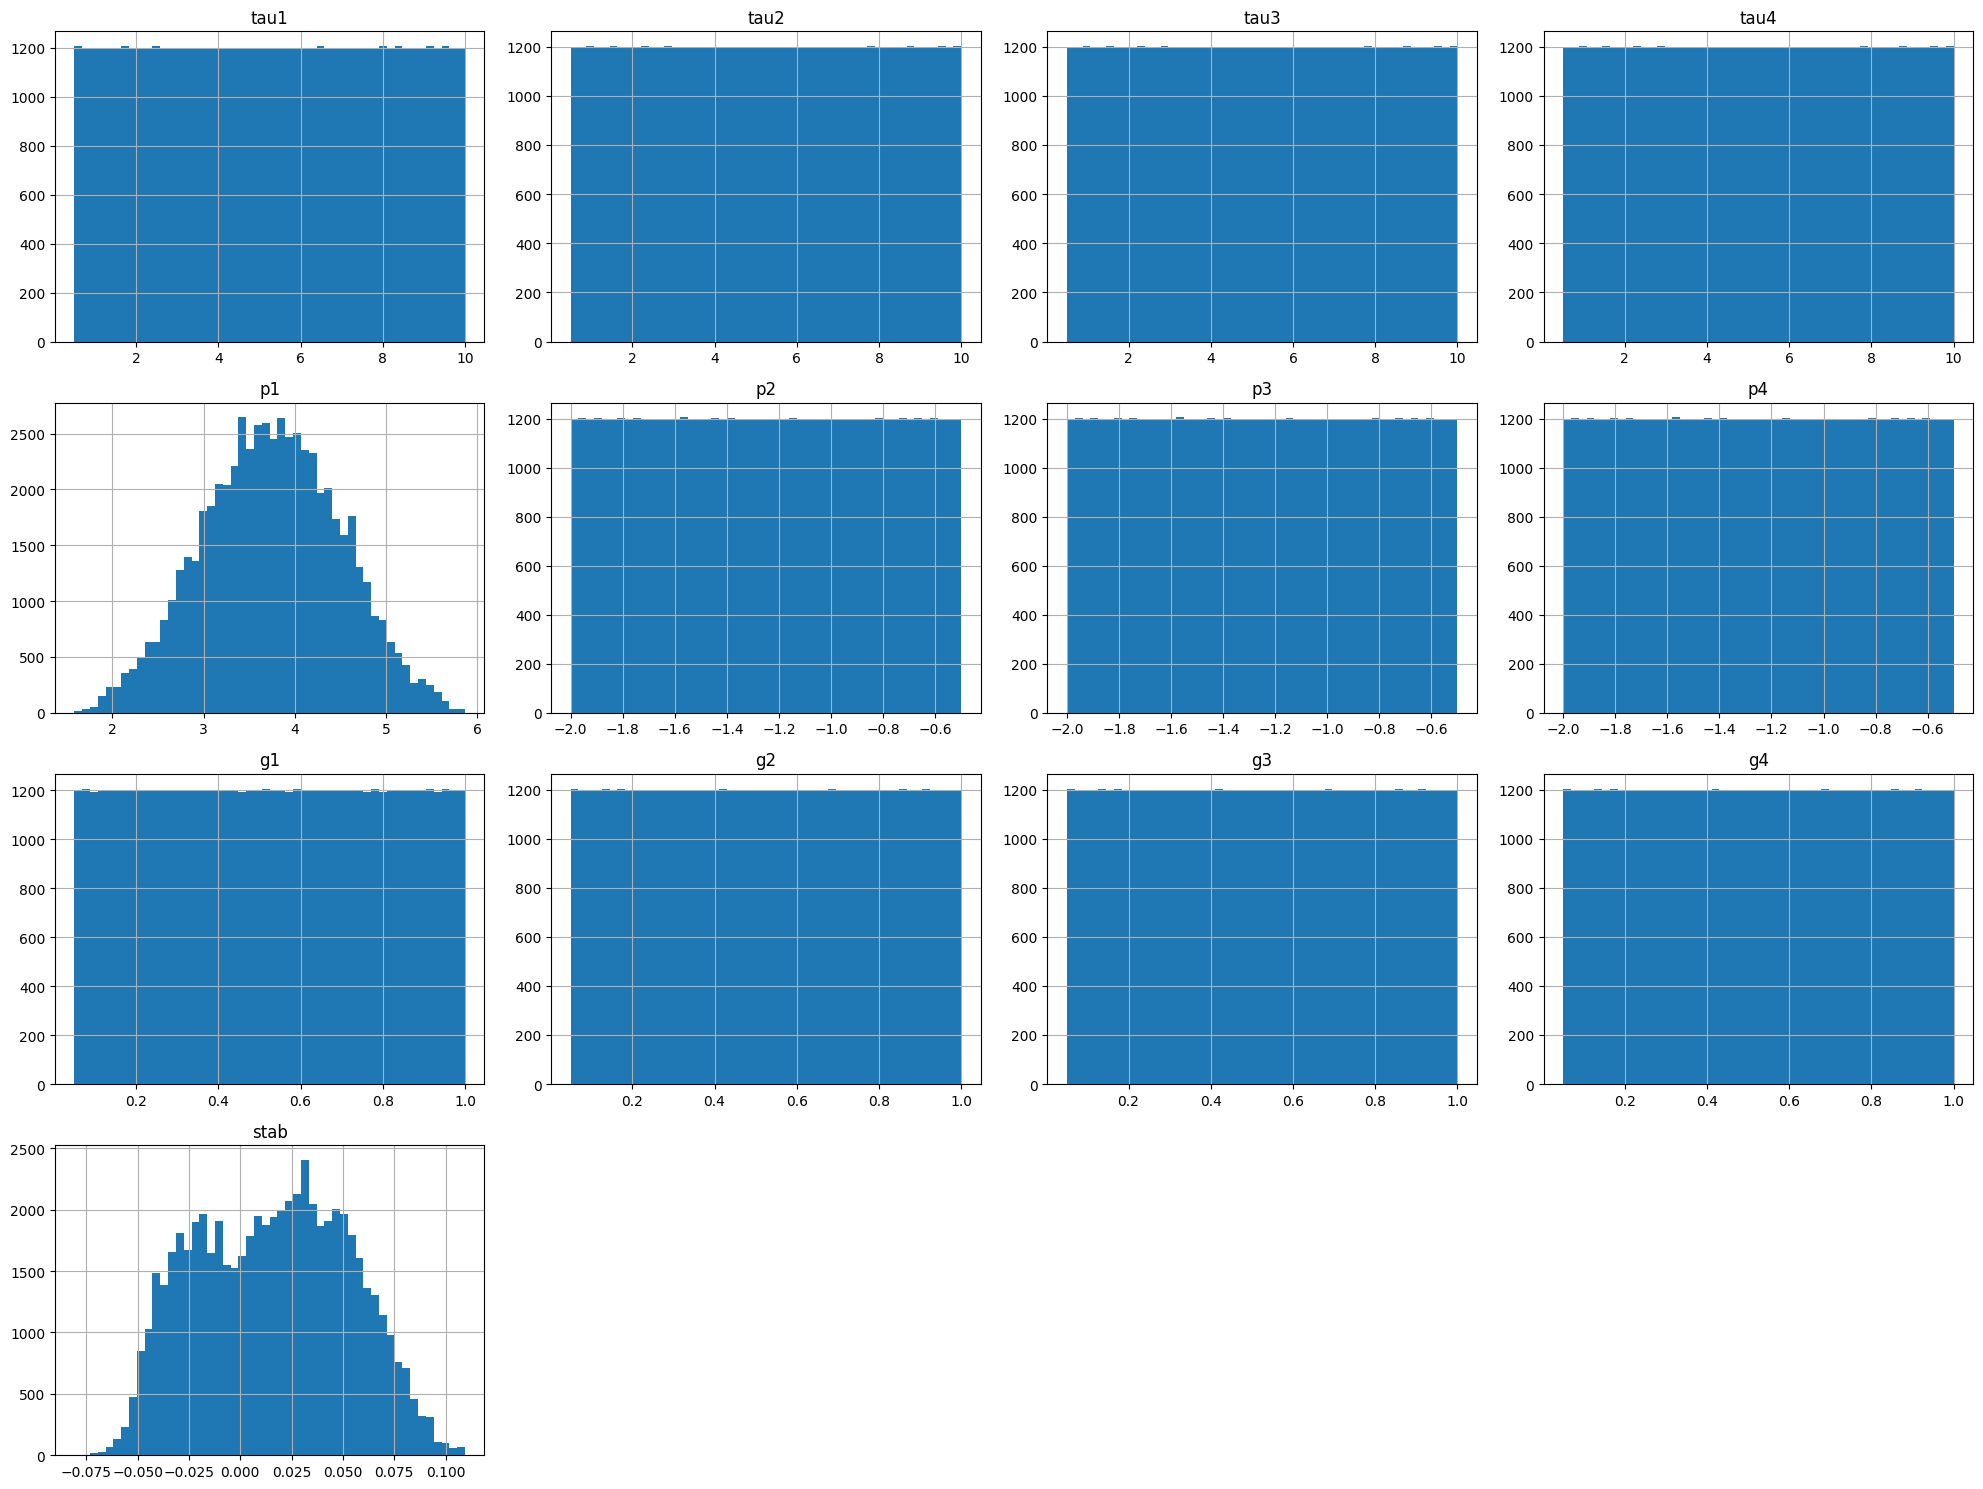

In [10]:
df.hist(bins=50, figsize=(20, 15))
plt.tight_layout()
plt.show()

In [11]:
df['stabf'] = df['stabf'].map({
    'stable': 1,
    'unstable': 0
})
df.head()

,tau1,tau2,tau3,tau4,p1,p2,p3,p4,g1,g2,g3,g4,stab,stabf
0,2.959060,3.079885,8.381025,9.780754,3.763085,-0.782604,-1.257395,-1.723086,0.650456,0.859578,0.887445,0.958034,0.055347,0
1,9.304097,4.902524,3.047541,1.369357,5.067812,-1.940058,-1.872742,-1.255012,0.413441,0.862414,0.562139,0.781760,-0.005957,1
2,8.971707,8.848428,3.046479,1.214518,3.405158,-1.207456,-1.277210,-0.920492,0.163041,0.766689,0.839444,0.109853,0.003471,0
3,0.716415,7.669600,4.486641,2.340563,3.963791,-1.027473,-1.938944,-0.997374,0.446209,0.976744,0.929381,0.362718,0.028871,0
4,3.134112,7.608772,4.943759,9.857573,3.525811,-1.125531,-1.845975,-0.554305,0.797110,0.455450,0.656947,0.820923,0.049860,0


In [12]:
y = df.iloc[:, -1]
X = df.drop('stabf', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=56)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state = 156)

In [13]:
X_train.shape, y_train.shape

((48000, 13), (48000,))

In [14]:
X_test.shape, y_test.shape

((6000, 13), (6000,))

In [15]:
pca = PCA(n_components=2)
x2d = pca.fit_transform(X)
x2d_df = pd.DataFrame(x2d)

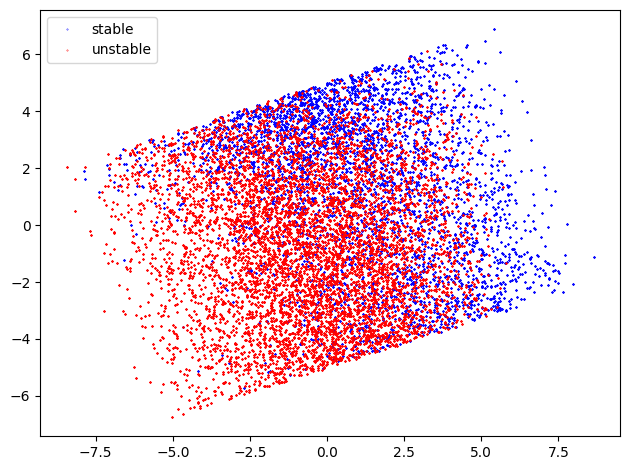

In [16]:
plt.plot(x2d_df[0][y==1], x2d_df[1][y==1], 'b.', ms=0.6, label='stable')
plt.plot(x2d_df[0][y==0], x2d_df[1][y==0], 'r.', ms=0.6, label='unstable')
plt.legend(loc="upper left")
plt.tight_layout()
plt.show()

In [17]:
def draw_cm(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    cm = pd.DataFrame(cm, index=['unstable', 'stable'], columns=['unstable', 'stable'])
    cm_sns = sns.heatmap(cm, cmap="Blues", annot=True)
    cm_sns.set_xlabel('predicted')
    cm_sns.set_ylabel('actual')
    plt.show()

In [18]:
# Define models with default parameters
svm_model = SVC()
dt_model = DecisionTreeClassifier()
knn_model = KNeighborsClassifier()

# Train each model
svm_model.fit(X_train, y_train)
dt_model.fit(X_train, y_train)
knn_model.fit(X_train, y_train)

KNeighborsClassifier()

In [19]:
# Define hyper-parameter grids for each model
svm_param_grid = {'kernel': ['linear', 'rbf'], 'C': [0.1, 1, 10]}
dt_param_grid = {'criterion': ['gini', 'entropy'], 'max_depth': [None, 5, 10]}
knn_param_grid = {'n_neighbors': [3, 5, 7], 'weights': ['uniform', 'distance']}

# Perform grid search for each model
svm_grid_search = GridSearchCV(svm_model, svm_param_grid, cv=5)
dt_grid_search = GridSearchCV(dt_model, dt_param_grid, cv=5)
knn_grid_search = GridSearchCV(knn_model, knn_param_grid, cv=5)

svm_grid_search.fit(X_train, y_train)
dt_grid_search.fit(X_train, y_train)
knn_grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [3, 5, 7],
                         'weights': ['uniform', 'distance']})

In [24]:
# Evaluate each model on the test data
svm_score = svm_grid_search.score(X_test, y_test)
dt_score = dt_grid_search.score(X_test, y_test)

In [25]:
# Import necessary libraries
from sklearn.metrics import confusion_matrix

# Predict the labels for the test data using each model
svm_predictions = svm_grid_search.predict(X_test)
dt_predictions = dt_grid_search.predict(X_test)
knn_predictions = knn_grid_search.predict(X_test)

# Calculate the confusion matrix for each model
svm_cm = confusion_matrix(y_test, svm_predictions)
dt_cm = confusion_matrix(y_test, dt_predictions)
knn_cm = confusion_matrix(y_test, knn_predictions)

# Print the confusion matrices
print("SVM Confusion Matrix:\n", svm_cm)
print("\nDecision Tree Confusion Matrix:\n", dt_cm)
print("\nKNN Confusion Matrix:\n", knn_cm)

SVM Confusion Matrix:
 [[3795    6]
 [  19 2180]]

Decision Tree Confusion Matrix:
 [[3801    0]
 [   0 2199]]

KNN Confusion Matrix:
 [[3381  420]
 [ 636 1563]]


In [35]:
# Create a dictionary to store the best parameters for each model.
best_params = {
    "SVM": {"C": 10, "gamma": 0.1, "kernel": "rbf"},
    "Decision Tree": {"criterion": "gini", "max_depth": 5, "min_samples_split": 2},
    "KNN": {"n_neighbors": 5, "weights": "uniform"},
}

# Print the best parameters for each model.
for model_name, params in best_params.items():
    print(f"Best parameters for {model_name}:")
    for param_name, param_value in params.items():
        print(f"\t{param_name}: {param_value}")

Best parameters for SVM:
	C: 10
	gamma: 0.1
	kernel: rbf
Best parameters for Decision Tree:
	criterion: gini
	max_depth: 5
	min_samples_split: 2
Best parameters for KNN:
	n_neighbors: 5
	weights: uniform


In [34]:
print("Best parameters for Decision Tree classification")

Best parameters for Decision Tree classification
